# Function Definition


In [2]:
import pandas as pd
import numpy as np
import warnings, os, json
warnings.simplefilter('ignore')
import matplotlib.pyplot as plt
%matplotlib inline

def load_log(log_file: str):
    with open(log_file, 'r') as file:
        lines = [x.split(' | ') for x in file.read().splitlines() if ('IbftRound' in x) or ('QbftRound' in x)]
        lines = [line for line in lines if len(line) > 1]
    result = {}
    for i in range(len(lines)):
        result[i] = lines[i]
    
    j = json.dumps(result)
    df = pd.read_json(j, orient='index')
    df.rename(columns={0: 'Timestamp',
                        1: 'Process',
                        2: 'LogLevel',
                        3: 'LogSource',
                        4: 'Description'}, inplace=True)

    df['Timestamp'] = pd.to_datetime(df.Timestamp, infer_datetime_format=True, utc=True).dt.tz_convert(None)
    df_temp = df.loc[:, 'Description'].str.split('\. round=ConsensusRoundIdentifier', expand=True)
    df.loc[:, 'Action'] = df_temp[0].values
    df.loc[:, 'Order'] = df_temp[1].values
    df_des = df.Order.str.split('Sequence=', expand=True)[1].str.split('\, Round=', expand=True)
    df.loc[:, 'Sequence'] = df_des[0].astype(int)
    df.loc[:, 'Round'] = df_des[1].str.split('\}', expand=True)[0].astype(int)

    df.reset_index(inplace=True)
    df.drop(columns=['index', 'Description','Order'], axis=1, inplace=True)
    return df

def logs2df(logpath):
    files = [file for file in os.listdir(logpath) if 'besu' in file and '.log' in file]
    df_list = []
    for file in files:
        logfile = os.path.join(logpath, file)
        if os.stat(logfile).st_size == 0:
            continue
        df = load_log(logfile)
        node_num = int(file.split('.')[0].split('-')[1])
        df['Node'] = node_num
        df_list.append(df)
    df = pd.concat(df_list)
    df_non_empty_blksize = get_non_empty_block_df(logfile)
    df_ne_blktime = df[df.Sequence.isin(df_non_empty_blksize.BlockNum.values)]
    # df_em_blktime = df[~df.Sequence.isin(df_non_empty_blksize.BlockNum.values)]
    return df_non_empty_blksize, df_ne_blktime

def cal_time_delta(send: str, receive: str, df: pd.DataFrame) -> list:
    t_delta_ls = []
    sequences = df.Sequence.unique()
    for seq in sequences:
        df_seq = df.loc[df.Sequence == seq]
        if send in df_seq.Action.unique() and 'proposed' in send:
            c_time = pd.to_datetime(df_seq[df_seq.Action == send].Timestamp.values[0], utc=True)
            df_r = df_seq.loc[df_seq.Action == receive]
            for _, row in df_r.iterrows():
                t_delta = pd.to_datetime(row.Timestamp, utc=True) - c_time
                t_delta_ls.append(t_delta.total_seconds())
        else:
            df_send = df_seq.loc[df_seq.Action == send].sort_values('Timestamp')
            df_receive = df_seq.loc[df_seq.Action == receive].reset_index()
            sendNodes = len(df_send.Node.unique())
            receiveNodes = len(df_receive.Node.unique())
            if sendNodes == receiveNodes or sendNodes+1 == receiveNodes:
                ts = []
                for node in df_receive.Node.unique():
                    t = list(pd.to_datetime(df_receive.loc[df_receive.Node == node].Timestamp.values, utc=True))
                    ts.append(t)
                for _, row in df_send.iterrows():
                    sts = pd.to_datetime(row.Timestamp, utc=True)
                    for i in range(len(ts)):
                        if (row.Node != (i+1)) and ts[i]:
                            rts = ts[i].pop(0)
                            deltatime = (rts - sts).total_seconds()
                            t_delta_ls.append(deltatime)
    return t_delta_ls

def cal_process_time(df):
    t_process_proposal, t_process_prepare, t_process_commit = [], [], []
    sequences = df.Sequence.unique()
    for seq in sequences:
        df_seq = df.loc[df.Sequence == seq]
        for _, row in df_seq.iterrows():
            if row.Action == 'Received a proposal message':
                rts_prop = pd.to_datetime(row.Timestamp, utc=True)
                continue
            if row.Action == 'Sending prepare message':
                sts_prep = pd.to_datetime(row.Timestamp, utc=True)
                t_process_proposal.append((sts_prep - rts_prop).total_seconds())
            if row.Action == 'Received a prepare message':
                rts_prep = pd.to_datetime(row.Timestamp, utc=True)
                continue
            if row.Action == 'Sending commit message':
                sts_commit = pd.to_datetime(row.Timestamp, utc=True)
                t_process_prepare.append((sts_commit - rts_prep).total_seconds())
            if row.Action == 'Received a commit message':
                rts_commit = pd.to_datetime(row.Timestamp, utc=True)
                continue
            if row.Action == 'Importing block to chain':
                sts_import = pd.to_datetime(row.Timestamp, utc=True)
                t_process_commit.append((sts_import - rts_commit).total_seconds())
    return t_process_proposal, t_process_prepare, t_process_commit

def cal_consensus_time(df: pd.DataFrame) -> list:
    consensus_time = []
    for seq in df.Sequence.unique():
        df_seq = df.loc[(df.Sequence == seq) & ((df.Action.str.contains('block') | df.Action.str.contains('proposal')))].sort_values('Timestamp')
        ts = df_seq.Timestamp.values
        delta_t = pd.Timedelta(ts[-1] - ts[0]).total_seconds()
        consensus_time.append(delta_t)
    return consensus_time

def remove_outlier_IQR(ts):
    Q1=np.percentile(a=ts, q=25)
    Q3=np.percentile(a=ts, q=75)
    IQR = Q3 - Q1
    ts_final = [t for t in ts if t > Q1 - 1.5*IQR and t < Q3 + 1.5*IQR]
    return ts_final

def plot_hist(ts, ax=None, upper=None, bins=50, title='Frequency Histogram', xlabel='Time (ms)', ylabel='Frequency'):
    '''
    ts: time list in seconds
    upper(option): upper threshold in seconds
    bins: number of bins in histogram plot
    '''
    ax = ax or plt.gca()
    x = [1000*t for t in ts]
    if upper:
        x = [1000*t for t in ts if t>0 and t<upper]
    hist = ax.hist(x, bins=bins)
    ax.set(title=title, xlabel=xlabel, ylabel=ylabel)
    return hist

def get_non_empty_block_df(log_file):
    with open(log_file, 'r') as file:
        lines = [x.split(' | ') for x in file.read().splitlines() if 'QbftBesuControllerBuilder' in x]
        lines = [line for line in lines if len(line) > 1]
    result = {}
    for i in range(len(lines)):
        result[i] = lines[i]

    j = json.dumps(result)
    df = pd.read_json(j, orient='index')
    df.rename(columns={0: 'Timestamp',
                        1: 'Process',
                        2: 'LogLevel',
                        3: 'LogSource',
                        4: 'Description'}, inplace=True)

    df['Timestamp'] = pd.to_datetime(df.Timestamp, infer_datetime_format=True, utc=True)
    df_des = df.loc[:, 'Description'].str.split('/', expand=True)
    df_des.rename(columns={0: 'BlockNum',
                    1: 'BlockSize',
                    2: 'Pending',
                    3: 'Gas',
                    4: 'BlockHash'}, inplace=True)
    df_des = df_des.replace(',','', regex=True)
    df_des['BlockNum'] = df_des.BlockNum.str.split('#', expand=True)[1].astype(int)
    df_des['BlockSize'] = df_des.BlockSize.str.split('tx', expand=True)[0].astype(int)
    df_des['Pending'] = df_des.Pending.str.split('pending', expand=True)[0].astype(int)
    df_des['Gas'] = df_des.Gas.str.split('(', expand=True)[0].astype(int)
    df = df_des[(df_des.BlockSize != 0) & (df_des.BlockSize != 1)]
    return df

def cal_consensus_ts(df: pd.DataFrame) -> list:
    consensus_time = []
    for seq in df.Sequence.unique():
        df_seq = df.loc[(df.Sequence == seq) & ((df.Action.str.contains('block') | df.Action.str.contains('proposal')))].sort_values('Timestamp')
        ts = df_seq.Timestamp.values
        delta_t = pd.Timedelta(ts[-1] - ts[0]).total_seconds()
        consensus_time.append(delta_t)
    return consensus_time

def findlogs(reporttimes, logdirlist):
    logs = []
    for reporttime in reporttimes:
        for logtime in logdirlist:
            if logtime > reporttime:
                logs.append(logtime)
                break
    return logs

# Block Size Box Plot


## Baseline


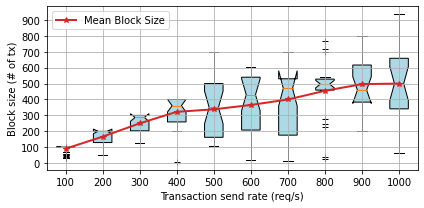

In [3]:
df = pd.read_csv('./data/df8_blksize_base.csv')
sendrates = df.SendRate.unique()
data, data_mean = [], []
for rate in sendrates:
    size = list(df[df.SendRate == rate].BlockSize)
    data.append(size)
    data_mean.append(np.mean(size))
    

fig, ax = plt.subplots(figsize=(6, 3))
X_axis = np.arange(1, len(sendrates)+1)
showfliers=True
showmeans=False
patch_artist=True

positions = np.arange(1, len(sendrates)+1)

ax.boxplot(data, positions=positions, sym='k+', notch=1, showfliers=showfliers, showmeans=showmeans, patch_artist=patch_artist, boxprops=dict(facecolor="lightblue"), zorder=1)
ax.plot(positions, data_mean, color='tab:red', label='Mean Block Size', marker='*', linewidth=2, zorder=2)
ax.grid()

ax.set_yticks(np.arange(0,1000,100))
ax.set_xlabel('Transaction send rate (req/s)')
ax.set_ylabel('Average Throughput (TPS)')

ax.set_ylabel('Block size (# of tx)')

ax.set_xticks(positions)
ax.set_xticklabels(sendrates)
ax.legend()
plt.tight_layout()
plt.show()

fig.set_size_inches(6,3)
# fig.savefig('./figs/blksize.png', dpi=300)
fig.savefig('./figs/blksize.pdf')

# total blk	383
# total tx	99432

# Consensus Time

QbftBesuControllerBuilder df1; PersistBlockTask df2
59:30.163 - 59:30.108
calculate all none-zero block size, consensus time, import time (persist time)

1. consensus time = TS_last importing - TS_creating proposal
2. persist time = TS_imported - TS_importing
3. for proposer: TS_produced - TS_importing


## Impact of net size


In [2]:
netsizes = np.arange(4,38,2)

reportpaths, logpaths = [], []

logspath = '/home/ubuntu/mnt/bpet/data'
logdirlist = os.listdir(logspath)
logdirlist = sorted([d.removeprefix('logs-') for d in logdirlist])

reportpaths, logpaths = {}, {}

for size in netsizes:
    reportpath = '/home/ubuntu/mnt/experiments_bpet/reports/{}_LB_2C7.5G_QBFT_1S'.format(size)

    reportdirs = sorted(os.listdir(reportpath))
    folders = [os.path.join(reportpath, d) for d in reportdirs]
    reportpaths[size] = folders

    logdirs = sorted(findlogs(reportdirs, logdirlist))
    folders = [os.path.join(logspath, 'logs-'+d) for d in logdirs]
    logpaths[size] = folders

In [22]:
# roundchange statistics
round_change = []
for size in netsizes:
    discard_num = 0
    rc_num = 0
    path = logpaths[size][0]
    logfile = os.path.join(path, 'besu-{}.log'.format(size))
    with open(logfile, 'r') as f:
        log = f.read().splitlines()
        discard_log = [ x for x in log if 'Discarding a message' in x]
        discard_num = len(discard_log)
        rc_log = [x for x in log if 'RoundChange' in x]
        rc_num = len(rc_log)
    print('{} has {} Discarding, and {} RoundChange messages.'.format(os.path.join(path, logfile), discard_num, rc_num))
    round_change.append(rc_num)

/home/ubuntu/mnt/bpet/data/logs-20220413-014843/besu-4.log has 3700 Discarding, and 0 RoundChange messages.
/home/ubuntu/mnt/bpet/data/logs-20220413-062330/besu-6.log has 7644 Discarding, and 0 RoundChange messages.
/home/ubuntu/mnt/bpet/data/logs-20220415-004605/besu-8.log has 8876 Discarding, and 0 RoundChange messages.
/home/ubuntu/mnt/bpet/data/logs-20220413-105758/besu-10.log has 24039 Discarding, and 0 RoundChange messages.
/home/ubuntu/mnt/bpet/data/logs-20220413-153336/besu-12.log has 18007 Discarding, and 0 RoundChange messages.
/home/ubuntu/mnt/bpet/data/logs-20220413-201034/besu-14.log has 15918 Discarding, and 0 RoundChange messages.
/home/ubuntu/mnt/bpet/data/logs-20220504-043906/besu-16.log has 36349 Discarding, and 0 RoundChange messages.
/home/ubuntu/mnt/bpet/data/logs-20220505-032913/besu-18.log has 30489 Discarding, and 0 RoundChange messages.
/home/ubuntu/mnt/bpet/data/logs-20220502-194521/besu-20.log has 22654 Discarding, and 2 RoundChange messages.
/home/ubuntu/mnt

In [8]:
# calculate consensus time from logs
data = []
for size in netsizes:
    consensus_time = []
    for logdir in logpaths[size]:
        # print('Calculating netsize {} for log dir {}'.format(size, logdir))
        _, df_cs = logs2df(logdir)
        cons_time = cal_consensus_ts(df_cs)
        consensus_time += cons_time
    data.append(consensus_time)

with open('./data/ct_all.json', 'w') as f:
    json.dump({'data': data}, f, indent=4) 

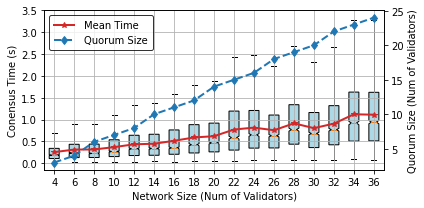

In [4]:
import math
# load consensus time from Json file
with open('./data/ct_all.json', 'r') as f:
    data = json.load(f)['data']
    
netsizes = np.arange(4,38,2)
quorum = [math.ceil(2/3 * size) for size in netsizes]

data_mean = []
for d in data:
    data_mean.append(np.mean(d))

fig, ax = plt.subplots(figsize=(6,3))

showfliers = False
showmeans = False
patch_artist = True

X_axis = np.arange(1, len(netsizes)+1)
xlabels = netsizes
positions = X_axis

bp = ax.boxplot(data, positions=positions, sym='k+', notch=1, showfliers=showfliers, showmeans=showmeans, patch_artist=patch_artist, boxprops=dict(facecolor="lightblue"), zorder=1)

ax.plot(X_axis, data_mean, 'tab:red', marker='*', linewidth=2, label='Mean Time', zorder=2)

ax2 = ax.twinx()
ax2.set_ylabel('Quorum Size (Num of Validators)')
ax2.plot(X_axis, quorum, 'tab:blue', linestyle='--', marker='d', linewidth=2, label='Quorum Size', zorder=3)
handles1, labels1 = ax.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax2.legend((*handles1, *handles2), (*labels1, *labels2),
             loc='upper left', ncol=1, handlelength=2, edgecolor='black',
             borderpad=0.5, handletextpad=1, columnspacing=0)

ax.set_xlabel('Network Size (Num of Validators)')
ax.set_ylabel('Conensus Time (s)')
ax.set_yticks(np.arange(0,4,0.5))
ax.set_xticks(X_axis)
ax.set_xticklabels(xlabels)
# ax.legend()
ax.grid()

plt.tight_layout()
plt.show()

fig.set_size_inches(6,3)
# fig.savefig('./figs/ct_netsize.png', dpi=300)
fig.savefig('./figs/ct_netsize.pdf')

## Impact of node size


In [5]:
def calculate_data():
    # get log paths
    flavors = ['1C7.5G', '2C7.5G', '2C15G', '4C15G', '4C30G', '8C30G', '16C60G']
    reportpaths, logpaths = [], []
    logspath = '/home/ubuntu/mnt/bpet/data'
    logdirlist = os.listdir(logspath)
    logdirlist = sorted([d.removeprefix('logs-') for d in logdirlist])
    reportpaths, logpaths = {}, {}

    for f in flavors:
        reportpath = '/home/ubuntu/mnt/experiments_bpet/reports/8_LB_{}_QBFT_1S'.format(f)
        reportdirs = sorted(os.listdir(reportpath))
        folders = [os.path.join(reportpath, d) for d in reportdirs]
        reportpaths[f] = folders
        logdirs = sorted(findlogs(reportdirs, logdirlist))
        folders = [os.path.join(logspath, 'logs-'+d) for d in logdirs]
        logpaths[f] = folders

    # calculate consensus time from logs
    data = []
    for f in flavors:
        consensus_time = []
        for logdir in logpaths[f]:
            print('Calculating consensus time {} for log dir {}'.format(f, logdir))
            _, df_cs = logs2df(logdir)
            cons_time = cal_consensus_ts(df_cs)
            consensus_time += cons_time
        data.append(consensus_time)

In [6]:
import pickle
datafile = './data/ct_nodesize.pickle'
if not (os.path.exists(datafile)):
    print("Data file does not exist! Calculating from logs...")
    data = calculate_data()
    with open(datafile, 'wb') as f:
        pickle.dump(data, f)
else:
    print('Data file {} exists!'.format(datafile))
    with open(datafile, 'rb') as f:
        data = pickle.load(f)

Data file ./data/ct_nodesize.pickle exists!


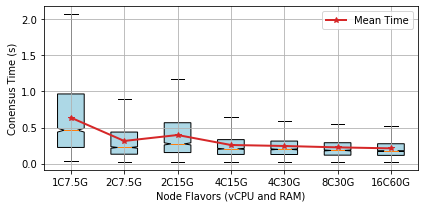

In [7]:
data_mean = []
for d in data:
    data_mean.append(np.mean(d))
flavors = ['1C7.5G', '2C7.5G', '2C15G', '4C15G', '4C30G', '8C30G', '16C60G']
fig, ax = plt.subplots(figsize=(6,3))

showfliers = False
showmeans = False
patch_artist = True

X_axis = np.arange(1, len(flavors)+1)
xlabels = flavors
positions = X_axis

# bp = ax.violinplot(data, positions=positions, showmeans=showmeans)
ax.boxplot(data, positions=positions, sym='k+', notch=1, showfliers=showfliers, showmeans=showmeans, patch_artist=patch_artist, boxprops=dict(facecolor="lightblue"), zorder=1)
ax.plot(X_axis, data_mean, 'tab:red', marker='*', linewidth=2, label='Mean Time', zorder=2)

ax.set_xlabel('Node Flavors (vCPU and RAM)')
ax.set_ylabel('Conensus Time (s)')
ax.set_xticks(X_axis)
ax.set_xticklabels(xlabels)
ax.legend()
ax.grid()

plt.tight_layout()
plt.show()

fig.set_size_inches(6,3)
# fig.savefig('./figs/consensus_time_flavor.png', dpi=300)
fig.savefig('./figs/consensus_time_flavor.pdf')

# Explore the relationship between blocksize and consensus time

- When tx arrives at txpool, proposer didn't pack them all into the next block, why?
- Which factors impact the selection of txs and the size of block?
- On transaction time, what is the service distribution? Service decomposition?
- How to determine the block size (gas limit) and block time (block period seconds) to meet your application need?

Performance research:
- Performance modelling: given specs of resources, node number, chain configuration parameters (e.g., block time), calculate performance?
- Resource provision: given requirement of performance, calculate how much resource is needed?

Model:
- Batch-service queue model D-BMAP/G^(l,c)/1
- Timing mechanism: only create block when there are transactions in the local txpool

In [1]:
def load_single_log(log_file: str):
    with open(log_file, 'r') as file:
        lines = [x.split(' | ') for x in file.read().splitlines() if 'BftProcessorExecutor-QBFT' in x]
        lines = [line for line in lines if len(line) > 1]
    result = {}
    for i in range(len(lines)):
        result[i] = lines[i]

    j = json.dumps(result)
    df = pd.read_json(j, orient='index')
    df.rename(columns={0: 'Timestamp',
                        1: 'Process',
                        2: 'LogLevel',
                        3: 'LogSource',
                        4: 'Description'}, inplace=True)
    df['Timestamp'] = pd.to_datetime(df.Timestamp, infer_datetime_format=True, utc=True).dt.tz_convert(None)
    df_temp = df.loc[:, 'Description'].str.split('\. round=ConsensusRoundIdentifier', expand=True)


    df.loc[:, 'Action'] = df_temp[0].values
    df.loc[:, 'Order'] = df_temp[1].values

    df = df.fillna(method='ffill').fillna(method='bfill')
    df_des = df.Order.str.split('Sequence=', expand=True)[1].str.split('\, Round=', expand=True)
    df.loc[:, 'Sequence'] = df_des[0].astype(int)
    df.loc[:, 'Round'] = df_des[1].str.split('\}', expand=True)[0].astype(int)
    
    df.reset_index(inplace=True)
    df.drop(columns=['index', 'Description','Order'], axis=1, inplace=True)
    return df
    
def parse_logs(logpath):
    files = [file for file in os.listdir(logpath) if 'besu' in file and '.log' in file]
    df_list = []
    for file in files:
        logfile = os.path.join(logpath, file)
        if os.stat(logfile).st_size == 0:
            continue
        df = load_single_log(logfile)
        node_num = int(file.split('.')[0].split('-')[1])
        df['Node'] = node_num
        df_list.append(df)
    df = pd.concat(df_list)
    new_seq = []
    for _, row in df.iterrows():
        seq = row['Sequence']+1 if row['Action'] == 'Starting new round 0' else row['Sequence']
        new_seq.append(seq)
    df['Sequence'] = new_seq
    return df

def cal_blksize_time(df_parsed):
    seqs = df_parsed.Sequence.unique()
    Sequence, ConsensusTime, Proposer, BlockSize, Pending, Gas = [], [], [], [], [], []
    for seq in seqs:
        df = df_parsed[df_parsed.Sequence == seq]
        if 'Creating proposed block' in df.Action.values:
            df_creater = df[df.Action == 'Creating proposed block']
            create_time = df_creater.Timestamp.values[0]
            proposer = df_creater.Node.values[0]
            df_imported = df[df.Action.str.contains('Imported|Produced', regex=True)]
            imported_times = df_imported.Timestamp.values
            consensus_ms = pd.Timedelta(max(imported_times) - create_time).total_seconds() * 1000
            segs = df_imported.Action.values[0].replace(',', '').split('/')

            BlockSize.append(int(segs[1].split(' tx')[0]))
            Pending.append(int(segs[2].split(' pending')[0]))
            Gas.append(int(segs[3].split(' (')[0]))
            Sequence.append(seq)
            ConsensusTime.append(consensus_ms)
            Proposer.append(proposer)

    data = {'BlockNum': Sequence, 'ConsensusTime': ConsensusTime, 'Proposer': Proposer, 'BlockSize': BlockSize, 'Pending': Pending, 'Gas': Gas}
    df_4nodes = pd.DataFrame(data)
    df = df_4nodes[~(df_4nodes.BlockSize.isin([0,1]))]
    df = df.reset_index().drop(columns='index')
    return df

In [3]:
log_path = '/home/ubuntu/mnt/experiments_bpet/data/logs-20220413-043053'
log_path = '/home/ubuntu/mnt/experiments_bpet/data/logs-20220413-033657'

In [4]:
df_parsed_4nodes = parse_logs(logpath=log_path)
df_parsed_4nodes

,Timestamp,Process,LogLevel,LogSource,Action,Sequence,Round,Node
0,2022-04-13 02:45:41.001,BftProcessorExecutor-QBFT-0,DEBUG,QbftBlockHeightManager,Starting new round 0,6589,0,2
1,2022-04-13 02:45:41.003,BftProcessorExecutor-QBFT-0,DEBUG,QbftRound,Received a proposal message,6588,0,2
2,2022-04-13 02:45:41.006,BftProcessorExecutor-QBFT-0,DEBUG,QbftRound,Sending prepare message,6588,0,2
3,2022-04-13 02:45:41.009,BftProcessorExecutor-QBFT-0,DEBUG,QbftRound,Received a prepare message,6588,0,2
4,2022-04-13 02:45:41.009,BftProcessorExecutor-QBFT-0,DEBUG,QbftRound,Received a prepare message,6588,0,2
...,...,...,...,...,...,...,...,...
42707,2022-04-13 03:36:47.008,BftProcessorExecutor-QBFT-0,DEBUG,QbftRound,Importing proposed block to chain,9654,0,1
42708,2022-04-13 03:36:47.010,BftProcessorExecutor-QBFT-0,DEBUG,TransactionLogBloomCacher,Caching logs bloom for block 0x25b6.,9654,0,1
42709,2022-04-13 03:36:47.010,BftProcessorExecutor-QBFT-0,INFO,QbftBesuControllerBuilder,"Imported #9,654 / 0 tx / 0 pending / 0 (0.0%) ...",9654,0,1
42710,2022-04-13 03:36:47.010,BftProcessorExecutor-QBFT-0,DEBUG,BaseBftController,Discarding a message which targets a height 96...,9654,0,1


In [5]:
df_calculated_4nodes = cal_blksize_time(df_parsed_4nodes)
df_calculated_4nodes

,BlockNum,ConsensusTime,Proposer,BlockSize,Pending,Gas
0,6616,541.0,4,55,41,2340833
1,6617,367.0,3,100,35,4179620
2,6618,283.0,2,100,26,4257260
3,6619,244.0,1,100,20,4180460
4,6620,220.0,4,100,20,4180460
...,...,...,...,...,...,...
377,9581,616.0,3,267,0,9411603
378,9609,644.0,3,756,244,31799400
379,9610,602.0,2,244,0,10234100
380,9635,1116.0,1,702,298,24728094


In [7]:
print(df_calculated_4nodes.reset_index()[['BlockSize', 'ConsensusTime', 'Gas']].corr())

               BlockSize  ConsensusTime       Gas
BlockSize       1.000000       0.836944  0.989394
ConsensusTime   0.836944       1.000000  0.800871
Gas             0.989394       0.800871  1.000000


In [9]:
print(df_calculated_4nodes.reset_index().drop(0)[['BlockSize', 'ConsensusTime', 'Gas']].corr())

               BlockSize  ConsensusTime       Gas
BlockSize       1.000000       0.840347  0.989366
ConsensusTime   0.840347       1.000000  0.804069
Gas             0.989366       0.804069  1.000000


<AxesSubplot:>

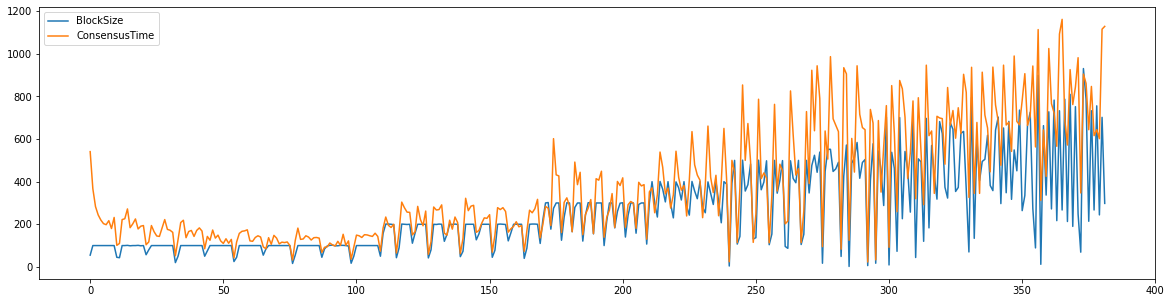

In [96]:
df.reset_index()[['BlockSize', 'ConsensusTime']].plot(figsize=(20, 5))

<AxesSubplot:>

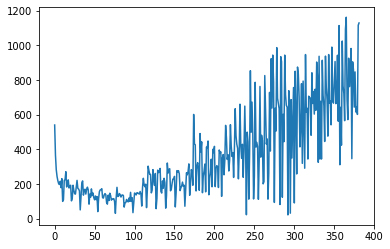

In [122]:
df_calculated_4nodes.ConsensusTime.plot()

<AxesSubplot:ylabel='Frequency'>

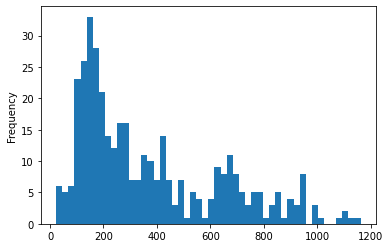

In [123]:
df_calculated_4nodes.ConsensusTime.plot.hist(bins=50)

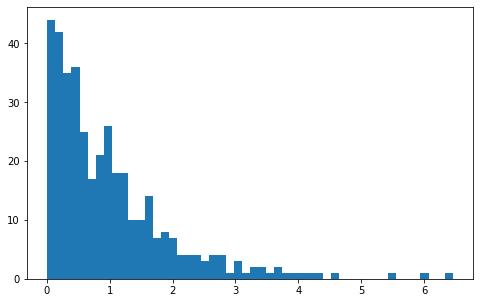

In [133]:
from numpy import random
import matplotlib.pyplot as plt


fig, ax = plt.subplots(figsize=(8,5))
ax.hist(random.exponential(scale=1, size=382), bins=50)
plt.show()
